In [1]:
import cv2
import os
import pandas as pd
from skimage.io import imread

def resize_cv(img):
    return cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

list_images = []
output = []

# Training
data_dir = r"C:\Users\aa\TRAFFIC SIGN RECOGNITION\GTSRB\Final_Training\Images"

#dirs = os.listdir(data_dir);
#for file in dirs:
#   print(file)

for dir in os.listdir(data_dir):
    if dir == '.DS_Store' :
        continue
    
    inner_dir = os.path.join(data_dir, dir)
    csv_file = pd.read_csv(os.path.join(inner_dir,"GT-" + dir + '.csv'), sep=';')
    for row in csv_file.iterrows() :
        img_path = os.path.join(inner_dir, row[1].Filename)
        img = imread(img_path)
        img = img[row[1]['Roi.X1']:row[1]['Roi.X2'],row[1]['Roi.Y1']:row[1]['Roi.Y2'],:]
        img = resize_cv(img)
        list_images.append(img)
        output.append(row[1].ClassId)


In [2]:
import keras
import tensorflow as tf
import numpy as np

# Split training set into training and validation set
input_array = np.stack(list_images)
# Converts a class vector (integers) to binary class matrix.
train_y = keras.utils.np_utils.to_categorical(output)

# If we divide directly then the model will not be get trained all the traffic signs as the dataset is not randomized.
randomize = np.arange(len(input_array))
np.random.shuffle(randomize)
x = input_array[randomize]
y = train_y[randomize]

# training = 60%
split_size = int(x.shape[0]*0.6)
train_x, val_x = x[:split_size], x[split_size:]
train1_y, val_y = y[:split_size], y[split_size:]

# test = 20%, validaton = 20%
split_size = int(val_x.shape[0]*0.5)
val_x, test_x = val_x[:split_size], val_x[split_size:]
val_y, test_y = val_y[:split_size], val_y[split_size:]

Using TensorFlow backend.


In [3]:
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.models import Sequential

hidden_num_units = 2048
hidden_num_units1 = 1024
hidden_num_units2 = 128
output_num_units = 43

epochs = 10
batch_size = 16
pool_size = (2, 2)
input_shape = Input(shape=(32, 32,3))

model = Sequential([
    
    Conv2D(16, (3, 3), activation = 'relu', input_shape = (64, 64, 3), padding = 'same'),
    BatchNormalization(),
    
    Conv2D(16, (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(pool_size = pool_size),
    Dropout(0.2),
    
    Conv2D(32, (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    
    Conv2D(32, (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(pool_size = pool_size),
    Dropout(0.2),
    
    Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(pool_size = pool_size),
    Dropout(0.2),
    
    Flatten(),
    
    Dense(units = hidden_num_units, activation = 'relu'),
    Dropout(0.3),
    Dense(units = hidden_num_units1, activation = 'relu'),
    Dropout(0.3),
    Dense(units = hidden_num_units2, activation = 'relu'),
    Dropout(0.3),
    Dense(units = output_num_units, input_dim = hidden_num_units, activation = 'softmax'),
])

model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=1e-4), metrics = ['accuracy'])

# Training the model
train_model_conv = model.fit(train_x.reshape(-1,64,64,3), train1_y, 
                             epochs=epochs, batch_size=batch_size, 
                             validation_data=(val_x, val_y))
# Predicting the classes
pred = model.predict_classes(test_x)

# Evaluating the model
model.evaluate(test_x, test_y)



Train on 23525 samples, validate on 7842 samples
Epoch 1/10
23525/23525 [==============================] - 310s 13ms/step - loss: 2.5393 - accuracy: 0.3238 - val_loss: 0.7723 - val_accuracy: 0.7845
Epoch 2/10
23525/23525 [==============================] - 311s 13ms/step - loss: 0.7622 - accuracy: 0.7698 - val_loss: 0.2081 - val_accuracy: 0.9373
Epoch 3/10
23525/23525 [==============================] - 305s 13ms/step - loss: 0.3164 - accuracy: 0.9034 - val_loss: 0.1049 - val_accuracy: 0.9667
Epoch 4/10
23525/23525 [==============================] - 304s 13ms/step - loss: 0.1808 - accuracy: 0.9441 - val_loss: 0.0578 - val_accuracy: 0.9829
Epoch 5/10
23525/23525 [==============================] - 304s 13ms/step - loss: 0.1085 - accuracy: 0.9654 - val_loss: 0.0504 - val_accuracy: 0.9847
Epoch 6/10
23525/23525 [==============================] - 305s 13ms/step - loss: 0.0855 - accuracy: 0.9732 - val_loss: 0.0451 - val_accuracy: 0.9867
Epoch 7/10
23525/23525 [==============================] -

[0.03545911469324958, 0.991073727607727]

In [9]:
model.save("tsr_model")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)       

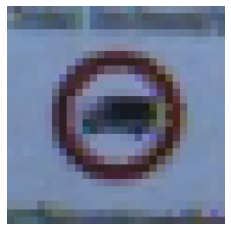

[8]
Speed limit (120km/h)


In [4]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras.preprocessing import image
from tensorflow import keras
from skimage.io import imread


def load_image(img_path, show=True):

    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    
    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

model = keras.models.load_model('tsr_model')

# Images from final_test, (00000, 12629) ppm files
img_path = r"C:\Users\aa\TRAFFIC SIGN RECOGNITION\GTSRB\Final_Test\Images\00999.ppm"
new_image = load_image(img_path)

final_img = imread(img_path)
final_img = cv2.resize(final_img, (64, 64), interpolation = cv2.INTER_AREA)
final_img = np.reshape(final_img,[1,64,64,3])

pred = model.predict_classes(final_img)

classes = [ 'Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)' , 'Speed limit (60km/h)',
            'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 
            'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 
            'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 
            'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 
            'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 
            'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 
            'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 
            'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 
            'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons' ]

print(pred)
print(classes[int(pred)])